# Project description

This project is devoted to the question-answering task. The aim is to work with the **BoolQ** dataset from SuperGLUE.

BoolQ is a question answering dataset for yes/no. 

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "answer": false,
      "title": "Time in France",
    }

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import re
import os
import string
import warnings
import json
from collections import Counter
from gensim import models
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import requests

import mlflow
from mlflow import pytorch as mltorch

sns.set()


DATA ANALYSIS

Train dataset length: 9427
+-----------+--------+----------------+-------------+
| Col names | Dtypes | Missing values | Mean length |
+-----------+--------+----------------+-------------+
|  question | object |       0        |    43.99    |
|  passage  | object |       0        |    590.17   |
|    idx    | int64  |       0        |      -      |
|   label   |  bool  |       0        |      -      |
+-----------+--------+----------------+-------------+


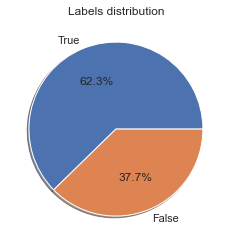

Number of unique words: 42758


In [7]:
MLFLOW_SERVER_URL = 'http://127.0.0.1:5000/'
experiment_name = 'BERT-word2vec'

warnings.filterwarnings("ignore")

client = mlflow.tracking.MlflowClient(MLFLOW_SERVER_URL)
mlflow.set_tracking_uri(MLFLOW_SERVER_URL)
mlflow.set_experiment(experiment_name)

# calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary. 
train_data = pd.read_json("./BoolQ/train.jsonl", orient="records", lines=True)
val_data = pd.read_json("./BoolQ/val.jsonl", orient="records", lines=True)

print("Train dataset length:", len(train_data))
table_info = PrettyTable()
table_info.add_column("Col names", list(train_data.columns))
table_info.add_column("Dtypes", list(train_data.dtypes.values))
table_info.add_column("Missing values", list(pd.isna(train_data).sum().values))
table_info.add_column("Mean length", [round(train_data["question"].str.len().sum() / len(train_data), 2), round(train_data["passage"].str.len().sum() / len(train_data), 2), '-', '-'])
print(table_info)

unique_labels = train_data["label"].value_counts()
plt.pie(unique_labels.values, labels=unique_labels.index, shadow=True, autopct='%.1f%%');
plt.title('Labels distribution');
plt.show()

punct_re = re.compile(r'[' + string.punctuation + r']')
double_space_re = re.compile(r"\s+")
train_data_tok = train_data.copy()
val_data_tok = val_data.copy()

train_data_tok["question"] = train_data_tok["question"].str.lower().apply(lambda x: re.sub(double_space_re, ' ', re.sub(punct_re, ' ', x))).str.split(' ')
train_data_tok["passage"] = train_data_tok["passage"].str.lower().apply(lambda x: re.sub(double_space_re, ' ', re.sub(punct_re, ' ', x))).str.split(' ')
val_data_tok["question"] = val_data_tok["question"].str.lower().apply(lambda x: re.sub(double_space_re, ' ', re.sub(punct_re, ' ', x))).str.split(' ')
val_data_tok["passage"] = val_data_tok["passage"].str.lower().apply(lambda x: re.sub(double_space_re, ' ', re.sub(punct_re, ' ', x))).str.split(' ')
total_words_dict = train_data_tok["passage"].apply(lambda x: Counter(x)).sum()
print("Number of unique words:", len(total_words_dict))


In [133]:
class EmbeddingVectorizer(object):
    def __init__(self, dim=30):
        self.word2vec = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.dim = dim

    def fit(self, X, y):
        return self

    def transform(self, X, type_='min'):
        """
        X is a list of tokenized sentences 
        example:
        X = [['the','cat,'sat','on','the','mat'],
             ['the','dog,'lies','on','the','sofe']]
        """
        res = []
        if type_ == "min":
            for sent in X:
                if len(sent) == 0:
                    res.append(np.zeros(self.dim))
                else:
                    current_vec = np.array([np.NaN for _ in range(self.dim)])
                    for word in sent:
                        try:
                            new_vec = np.array(self.word2vec.encode(word, max_length=self.dim, padding="max_length", truncation=True))
                            current_vec = np.fmin(current_vec, new_vec)
                        except KeyError:
                            pass
                    res.append(current_vec)
        elif type_ == "max":
            for sent in X:
                if len(sent) == 0:
                    res.append(np.zeros(self.dim))
                else:
                    current_vec = np.array([np.NaN for _ in range(self.dim)])
                    for word in sent:
                        try:
                            new_vec = np.array(self.word2vec.encode(word, max_length=self.dim, padding="max_length", truncation=True))
                            current_vec = np.fmax(current_vec, new_vec)
                        except KeyError:
                            pass
                    res.append(current_vec)
        elif type_ == "sum":
            for sent in X:
                if len(sent) == 0:
                    res.append(np.zeros(self.dim))
                else:
                    current_vec = np.zeros(self.dim)
                    for word in sent:
                        try:
                            current_vec += np.array(self.word2vec.encode(word, max_length=self.dim, padding="max_length", truncation=True))
                        except KeyError:
                            pass
                    res.append(current_vec)
        elif type_ == "mean":
            for sent in X:
                if len(sent) == 0:
                    res.append(np.zeros(self.dim))
                else:
                    current_vec = np.zeros(self.dim)
                    for word in sent:
                        try:
                            current_vec += np.array(self.word2vec.encode(word, max_length=self.dim, padding="max_length", truncation=True))
                        except KeyError:
                            pass
                    res.append(current_vec / len(sent))
        else:
            raise ValueError("Wrong transformation type: {}".format(type_))
        return res

vectorizer = EmbeddingVectorizer(dim=30)
X_train_ques_list = list(train_data_tok["question"].values)
X_train_pass_list = list(train_data_tok["passage"].values)
X_train_labels = np.array(train_data_tok["label"].astype("int").values)
X_test_ques_list = list(val_data_tok["question"].values)
X_test_pass_list = list(val_data_tok["passage"].values)
X_test_labels = np.array(val_data_tok["label"].astype("int").values)
sent_vectorizings = ['mean', 'min', 'max', 'sum']

w2v_training_res_table = PrettyTable()
w2v_training_res_table.add_column("Sent_Vectorizers", sent_vectorizings)
w2v_training_res_table.add_column("Model", ["RandomForest"]*len(sent_vectorizings))

accuracy_train_list = []
accuracy_test_list = []
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
for type_ in tqdm(sent_vectorizings):
    with mlflow.start_run():
        n_estimators = 300
        criterion = "gini"

        X_train_ques_vecs = vectorizer.transform(X_train_ques_list, type_=type_)
        X_train_pass_vecs = vectorizer.transform(X_train_pass_list, type_=type_)
        sentence_pairs = np.array(list(zip(X_train_ques_vecs, X_train_pass_vecs)))
        pairs_cosins_train = np.array(list(map(lambda x: cosine_similarity(x[0].reshape(1, -1), x[1].reshape(1, -1))[0][0], sentence_pairs)))
        rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, random_state=5)
        rf = rf.fit(pairs_cosins_train.reshape(-1, 1), X_train_labels.reshape(-1, 1))
        
        X_test_ques_vecs = vectorizer.transform(X_test_ques_list, type_=type_)
        X_test_pass_vecs = vectorizer.transform(X_test_pass_list, type_=type_)
        sentence_pairs = np.array(list(zip(X_test_ques_vecs, X_test_pass_vecs)))
        pairs_cosins_test = np.array(list(map(lambda x: cosine_similarity(x[0].reshape(1, -1), x[1].reshape(1, -1))[0][0], sentence_pairs)))
        y_train_pred = rf.predict(pairs_cosins_train.reshape(-1, 1))
        y_test_pred = rf.predict(pairs_cosins_test.reshape(-1, 1))

        accuracy_train_list.append(accuracy_score(X_train_labels, y_train_pred))
        accuracy_test_list.append(accuracy_score(X_test_labels, y_test_pred))
        precision_train_list.append(precision_score(X_train_labels, y_train_pred))
        precision_test_list.append(precision_score(X_test_labels, y_test_pred))
        recall_train_list.append(recall_score(X_train_labels, y_train_pred))
        recall_test_list.append(recall_score(X_test_labels, y_test_pred))
        f1_train_list.append(f1_score(X_train_labels, y_train_pred))
        f1_test_list.append(f1_score(X_test_labels, y_test_pred))

        accuracy_score(X_train_labels, y_train_pred)
        mlflow.log_metric("Accuracy", accuracy_score(X_test_labels, y_test_pred))
        precision_score(X_train_labels, y_train_pred)
        mlflow.log_metric("Precision", precision_score(X_test_labels, y_test_pred))
        recall_score(X_train_labels, y_train_pred)
        mlflow.log_metric("Recall", recall_score(X_test_labels, y_test_pred))
        f1_score(X_train_labels, y_train_pred)
        mlflow.log_metric("f1", f1_score(X_test_labels, y_test_pred))
        
        mlflow.log_param("n_estimators", n_estimators)
        mlflow.log_param("criterion", criterion)

        mlflow.sklearn.log_model(rf, "model")

experiment = client.get_experiment_by_name(experiment_name)
reg_model_name = "bert-rdf"
client.create_registered_model(reg_model_name)

# staging
run_info = client.list_run_infos(experiment.experiment_id)[0]
result = client.create_model_version(
    name=reg_model_name,
    source=f"{run_info.artifact_uri}/model",
    run_id=run_info.run_id
)
client.transition_model_version_stage(
    name=reg_model_name,
    version=result.version,
    stage="Staging"
)
# prod model
run_info = client.list_run_infos(experiment.experiment_id)[-1]
result = client.create_model_version(
    name=reg_model_name,
    source=f"{run_info.artifact_uri}/model",
    run_id=run_info.run_id
)
client.transition_model_version_stage(
    name=reg_model_name,
    version=result.version,
    stage="Production"
)

client = mlflow.tracking.MlflowClient(MLFLOW_SERVER_URL)
experiment = client.get_experiment_by_name(experiment_name)
client.list_run_infos(experiment.experiment_id)


w2v_training_res_table.add_column("train_accuracy", accuracy_train_list)
w2v_training_res_table.add_column("test_accuracy", accuracy_test_list)
w2v_training_res_table.add_column("train_precision", precision_train_list)
w2v_training_res_table.add_column("test_precision", precision_test_list)
w2v_training_res_table.add_column("train_recall", recall_train_list)
w2v_training_res_table.add_column("test_recall", recall_test_list)
w2v_training_res_table.add_column("train_f1", f1_train_list)
w2v_training_res_table.add_column("test_f1", f1_test_list)
print(w2v_training_res_table)


  0%|          | 0/4 [00:00<?, ?it/s]C:\Users\kidzu\AppData\Local\Temp/ipykernel_10756/1517069285.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(pairs_cosins_train.reshape(-1, 1), X_train_labels.reshape(-1, 1))
 25%|██▌       | 1/4 [01:25<04:15, 85.31s/it]C:\Users\kidzu\AppData\Local\Temp/ipykernel_10756/1517069285.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(pairs_cosins_train.reshape(-1, 1), X_train_labels.reshape(-1, 1))
 50%|█████     | 2/4 [02:44<02:42, 81.44s/it]C:\Users\kidzu\AppData\Local\Temp/ipykernel_10756/1517069285.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = rf.fit(pairs_cosins_train.reshape(-1,

+------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Sent_Vectorizers |    Model     |   train_accuracy   |   test_accuracy    |  train_precision   |   test_precision   |    train_recall    |    test_recall     |      train_f1      |      test_f1       |
+------------------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       mean       | RandomForest | 0.9234114776705209 | 0.5422018348623853 | 0.921190320470896  | 0.6255857544517338 | 0.9591419816138917 | 0.6566650270536154 | 0.9397831526271894 | 0.640748740100792  |
|       min        | RandomForest | 0.6276652169300944 | 0.618960244648318  | 0.6272335844994618 | 0.6225474929928371 | 0.9919986380660538 | 0.9832759468765372 | 0.7685307306779214 | 0

# Models f1-score update through MLFlow
Let's take a model with highest f1-score so that both precision and recall were high

In [ ]:
prod_model = [v for v in client.search_model_versions(f"name='{reg_model_name}'") if v.current_stage == "Production"][0]
prod_rmse = client.get_run(prod_model.run_id).data.metrics["rmse"]

check_ids = set()

for run_info in client.list_run_infos(experiment.experiment_id):
    run_metrics = client.get_run(run_info.run_id).data.metrics
    if run_metrics["f1"] >= prod_rmse:
        client.set_tag(run_info.run_id, "staging", "rc")
        client.set_tag(run_info.run_id, "compared_with", f"{prod_model.version}")
        check_ids.add(run_info.run_id)
    elif run_metrics["f1"] < prod_rmse:
        client.set_tag(run_info.run_id, "staging", "rejected")
        client.set_tag(run_info.run_id, "compared_with", f"{prod_model.version}")
    print(client.get_run(run_info.run_id).data.tags["staging"])


url = f'http://127.0.0.1:5005/invocations'
models_list = []

for run_id in check_ids:
    current_prod = [v for v in client.search_model_versions(f"name='{reg_model_name}'") if v.current_stage == 'Production'][-1]
    run_info = client.get_run(run_id).info
    if current_prod.run_id != run_id:
        result = client.create_model_version(
            name=reg_model_name,
            source=f"{run_info.artifact_uri}/model",
            run_id=run_id
        )
        models_list.append(result)
        client.transition_model_version_stage(
            name=reg_model_name,
            version=result.version,
            stage="Staging"
        )
        print(os.system('MLFLOW_TRACKING_URI=http://0.0.0.0:5000 mlflow models serve -m "models:/sk-learn-model-ci/Staging" -p 5005 --no-conda &'))
        http_data = pairs_cosins_test.to_json(orient='split')
        response = requests.post(url=url, headers={'Content-Type': 'application/json'}, data=http_data)
        test_rmse = np.sqrt(mean_squared_error(X_test_labels, response.json()))
        print(os.system('MLFLOW_TRACKING_URI=http://0.0.0.0:5000 mlflow models serve -m "models:/sk-learn-model-ci/Production" -p 5005 --no-conda &'))
        http_data = pairs_cosins_test.to_json(orient='split')
        response = requests.post(url=url, headers={'Content-Type': 'application/json'}, data=http_data)
        prod_rmse = np.sqrt(mean_squared_error(X_test_labels, response.json()))
        print(test_rmse, prod_rmse)
        if test_rmse >= prod_rmse:
            print("Swap")
            current_prod = [v for v in client.search_model_versions(f"name='{reg_model_name}'") if v.current_stage == 'Production'][-1]
            client.set_tag(current_prod.run_id, "staging", "rejected")
            client.transition_model_version_stage(
                name=reg_model_name,
                version=result.version,
                stage="Production"
            )
            current_prod = [v for v in client.search_model_versions(f"name='{reg_model_name}'") if v.current_stage == 'Production'][-1]
            client.set_tag(current_prod.run_id, "staging", "rc")
        else:
            client.set_tag(run_info.run_id, "staging", "rejected")
    else:
        print("Identical runs")


### Results of using word2vec model
The way model built:
* tokenizing words of each passage using BERT
* getting passages embeddings by three ways: "mean", "min", "max" and "sum"
* tokenizing words of each question using BERT
* getting questions embeddings by three ways: "mean", "min", "max" and "sum"
* getting cos similarity between question and passage
* training RandomForestClassifier with cos similarities and labels

Results:
* Accuracy on train dataset is between (0.62, 0.95);
* Accuracy on test set is between (0.54, 0.62);

Difference:
Test accuracy depends on the way of sents vectorizing. The best is word vectors min: 0.619.


In [8]:
BATCH_SIZE = 12
LR = 1e-5
EPOCHS = 10
MAX_SEQ_LEN = 256

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(13)
torch.manual_seed(13)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

model.to(device)

optimizer = AdamW(model.parameters(), lr=LR, eps=1e-8)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
def encode_data(tokenizer, questions, passages, max_length):
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first", add_special_tokens=True)
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

train_data, val_data = train_test_split(train_data, train_size=0.9, test_size=0.1)

passages_train = train_data["passage"].values
questions_train = train_data["question"].values
answers_train = train_data["label"].values

passages_val = val_data["passage"].values
questions_val = val_data["question"].values
answers_val = val_data["label"].values

input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, MAX_SEQ_LEN)
input_ids_val, attention_masks_val = encode_data(tokenizer, questions_val, passages_val, MAX_SEQ_LEN)

train_features = (input_ids_train, attention_masks_train, answers_train)
val_features = (input_ids_val, attention_masks_val, answers_val)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [10]:
train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]

train_dataset = TensorDataset(*train_features_tensors)
val_dataset = TensorDataset(*val_features_tensors)

train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=BATCH_SIZE)


In [11]:
grad_acc_steps = 1
train_loss_values = []
val_acc_values = []

for _ in tqdm(range(EPOCHS), desc="Epoch"):

    epoch_train_loss = 0
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()
      
        if (step+1) % grad_acc_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)
    train_loss_values.append(epoch_train_loss)
  
    epoch_val_accuracy = 0
    model.eval()

    for batch in val_dataloader:
    
        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
    
        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()
    
        epoch_val_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_val_accuracy = epoch_val_accuracy / len(val_dataloader)
    val_acc_values.append(epoch_val_accuracy)


Epoch: 100%|██████████| 10/10 [21:30<00:00, 129.09s/it]


In [12]:
device = torch.device("cpu")
model.to(device)
model.save_pretrained("updated_bert")


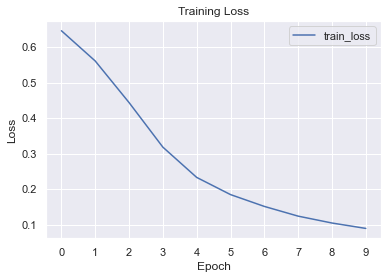

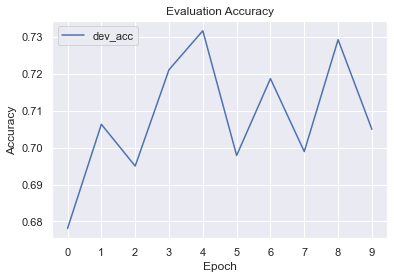

In [15]:
plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.xticks(np.arange(0, 10))
plt.show()

plt.plot(val_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.xticks(np.arange(0, 10))
plt.show()


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("updated_bert")
model.eval()
device = torch.device("cpu")
model.to(device)
val_data = pd.read_json("./BoolQ/val.jsonl", orient="records", lines=True)

passages_val = val_data["passage"].values
questions_val = val_data["question"].values
answers_val = val_data["label"].values
input_ids_val, attention_masks_val = encode_data(tokenizer, questions_val, passages_val, MAX_SEQ_LEN)
val_features = (input_ids_val, attention_masks_val, answers_val)
val_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in val_features]

val_dataset = TensorDataset(*val_features_tensors)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=len(val_data))

val_accuracy = 0
for batch in val_dataloader:
    
    input_ids = batch[0].to(device)
    attention_masks = batch[1].to(device)
    labels = batch[2]

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    predictions = np.argmax(logits, axis=1).flatten()
    labels = labels.numpy().flatten()

    val_accuracy += np.sum(predictions == labels) / len(labels)

val_accuracy = val_accuracy / len(val_dataloader)
print("Accuracy for trained model:", val_accuracy)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\kidzu\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Accuracy for trained model: 0.7220183486238532


### General results:
* best result for BERT embeddings: 0.619
* best result for neural network trainining after 10 epochs: 0.722

So BERT embeddings are better because it uses context for embeddings encoding.
That's why they help to get better results even with embeddings of smaller dimension.

Neural network with BERT gives best results because it trains the whole model for better questions answering and uses special dataset for it.
